In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import GloVe

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import matplotlib.pyplot as plt

In [56]:
file_path = '../data/processed/full_2k.csv'
full_2k = pd.read_csv(file_path)

In [57]:
le = LabelEncoder()
full_2k['label'] = le.fit_transform(full_2k['Category'])
num_classes = len(le.classes_)

print(full_2k[['Category', 'label']].head())

    Category  label
0  Biography      0
1   Religion      8
2  Biography      0
3    General      3
4    History      4


In [58]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)

full_2k['cleaned_desc'] = full_2k['Description'].apply(clean_text)

In [59]:
# First, split off 10% test
X_temp, X_test, y_temp, y_test = train_test_split(
    full_2k['cleaned_desc'], full_2k['label'], 
    test_size=0.1, stratify=full_2k['label'], random_state=13)

# Then split temp into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.11111111111111,
    stratify=y_temp, random_state=13)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 27543, Val: 3443, Test: 3443


In [60]:
glove = GloVe(name='6B', dim=50)  # 50-dimensional embeddings

def sentence_to_vec(sentence, glove):
    words = sentence.split()
    vecs = [glove[word] for word in words if word in glove.stoi]  # skip unknown words
    if len(vecs) == 0:
        return torch.zeros(glove.dim)
    return torch.mean(torch.stack(vecs), dim=0)

X_vectors = torch.stack(full_2k['cleaned_desc'].apply(lambda x: sentence_to_vec(x, glove)).tolist())

In [69]:
glove = GloVe(name='6B', dim=50)

def sentence_to_vec(sentence, glove):
    words = sentence.split()
    vecs = [glove[word] for word in words if word in glove.stoi]
    if len(vecs) == 0:
        return torch.zeros(glove.dim)
    return torch.mean(torch.stack(vecs), dim=0)

# Convert all splits to vectors
X_train_vectors = torch.stack(X_train.apply(lambda x: sentence_to_vec(x, glove)).tolist())
X_val_vectors = torch.stack(X_val.apply(lambda x: sentence_to_vec(x, glove)).tolist())
X_test_vectors = torch.stack(X_test.apply(lambda x: sentence_to_vec(x, glove)).tolist())

# Convert labels to tensors
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [70]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TextDataset(X_train_vectors, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TextDataset(X_val_vectors, y_val_tensor), batch_size=32)
test_loader = DataLoader(TextDataset(X_test_vectors, y_test_tensor), batch_size=32)

In [71]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = SimpleNN(input_dim=50, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/50, Train Loss: 1.4044, Val Loss: 1.0732
Epoch 2/50, Train Loss: 1.0533, Val Loss: 0.9901
Epoch 3/50, Train Loss: 0.9979, Val Loss: 0.9610
Epoch 4/50, Train Loss: 0.9695, Val Loss: 0.9423
Epoch 5/50, Train Loss: 0.9492, Val Loss: 0.9303
Epoch 6/50, Train Loss: 0.9332, Val Loss: 0.9187
Epoch 7/50, Train Loss: 0.9219, Val Loss: 0.9043
Epoch 8/50, Train Loss: 0.9090, Val Loss: 0.9055
Epoch 9/50, Train Loss: 0.9010, Val Loss: 0.8935
Epoch 10/50, Train Loss: 0.8913, Val Loss: 0.8863
Epoch 11/50, Train Loss: 0.8831, Val Loss: 0.8895
Epoch 12/50, Train Loss: 0.8768, Val Loss: 0.8792
Epoch 13/50, Train Loss: 0.8698, Val Loss: 0.8749
Epoch 14/50, Train Loss: 0.8651, Val Loss: 0.8718
Epoch 15/50, Train Loss: 0.8594, Val Loss: 0.8662
Epoch 16/50, Train Loss: 0.8528, Val Loss: 0.8667
Epoch 17/50, Train Loss: 0.8481, Val Loss: 0.8600
Epoch 18/50, Train Loss: 0.8418, Val Loss: 0.8593
Epoch 19/50, Train Loss: 0.8396, Val Loss: 0.8551
Epoch 20/50, Train Loss: 0.8356, Val Loss: 0.8593
Epoch 21/

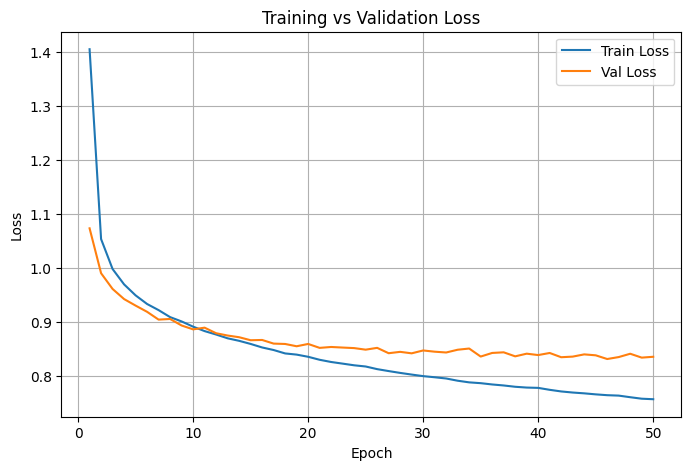

In [72]:
epochs = 50
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimiser.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimiser.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}")

# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_loss_history, label="Train Loss")
plt.plot(range(1, epochs+1), val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [76]:
with torch.no_grad():
    correct = 0
    total = 0
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.float()
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

print(f"Test Accuracy: {correct/total:.4f}")

Test Accuracy: 0.7142


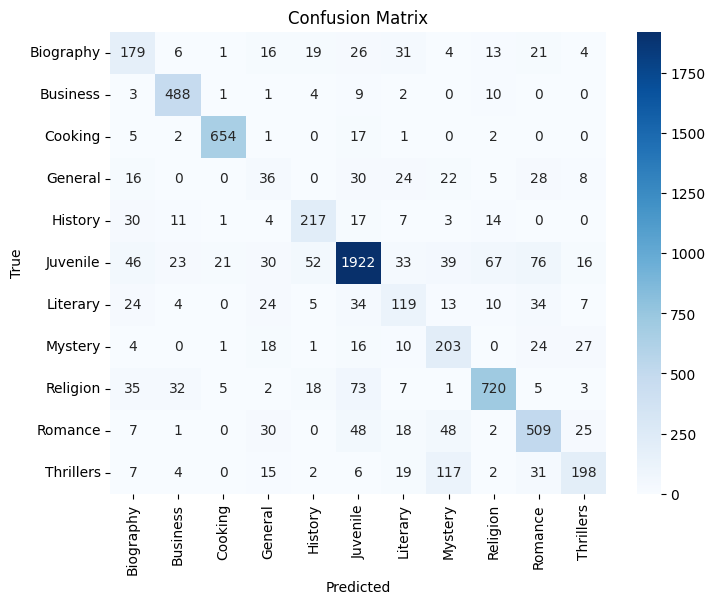

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
